## Edge signed graph problem

## Formulation

Let $G = (V,E,s)$ be a signed graph where $k \in \mathbb{N}$ and $1 \leq k \leq n$.

An edge $e \in E$ is called negative if $s(e) = −1$ and positive if $s(e) = +1$. 

Let $E^{-}$ and $E^{+}$ denote, respectively, the sets of negative and positive edges in a signed graph.

Let $K$ the sets of partition.

For a vertex set $S \subseteq V$ , let $E[S] = \{ (u,v) \in E \ | \ u,v \in S \}$ denote the subset of edges induced by $S$.

Let $S_i$ the partition $i$ of the $G$ where $i \in K = \{ 1,2, \ldots, k \}$.

A signed graph $G=(V,E,s)$ is $k$-balanced if $V$ can be partitioned into $S_1, S_2 , \ldots , S_l$ , with $l \leq k$, where $\cup_{i=1}^{l} E[S_i] = E^{+}$.

$
x_{vi} = 
\begin{cases}
1, & \text{ if } v \in S_i, \; \forall v \in V,\forall i \in K \\ 
0, & \text{otherwise}. 
\end{cases} 
$

$
y_{uv} = 
\begin{cases}
1, & \text{ if } (u,v) \text{ is removed}, \; \forall (u,v) \in E \\
0, & \text{ otherwise.} 
\end{cases} 
$

$$
\begin{align}
\min \quad & \sum\limits_{uv \in E} y_{uv} & \\
\text{s.t} \quad & \sum_{i \in [k]} x_{vi} \geq 1 & \forall v \in V  \\
& x_{ui} + x_{vi} \leq 1 + y_{uv} & \forall uv \in E^{-}, \forall i \in K \\
& x_{ui} \geq x_{vi} - y_{uv} & \forall uv \in E^{+}, \forall i \in K \\
& x_{vi} \geq x_{ui} - y_{uv} & \forall uv \in E^{+}, \forall i \in K \\
& x_{ui} + x_{vj} \leq 1 + y_{uv} &  \forall uv \in E^{+}, \; \forall i,j \in K, \; i \not= j \\
& x_{vi} \in \{0,1\} & \forall v \in V, \forall i \in K \\
& y_{vu} \in \{0,1\} & \forall uv \in E 
\end{align}
$$

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp

In [2]:
def edgesEN(G):
    EP = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]
    EN = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < 0]

    return EP, EN

In [3]:
# define tuple (vertice,partition)
def setVK(G,k):
    nodes = G.nodes()
    vk = []
    for u in nodes:
        for v in range(k):
            a = (u,v)
            vk.append(a)

    return vk

In [4]:
def read_instance(instance):
    with open(instance, 'r') as file: 
        lines = file.readlines()

    lines = [a.strip() for a in lines]

    values = lines[0].split()
    n, m = int(values[0]), int(values[1])

    #print("n =", n)
    #print("m =", m)

    G = nx.Graph()

    for u in range(n):
        G.add_node(u)

    for e in range(1,m+1):
        values = lines[e].split()
        u, v, val = int(values[0]), int(values[1]), int(values[2])
        G.add_edge(u, v, weight=val)

    return G


In [5]:
def plotGraph(G, pos):
    plt.figure(figsize=(25, 20))
    nx.draw_networkx(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

In [6]:
def position(G):
    #seed = 20532
    pos = nx.spring_layout(G)
    #pos=nx.random_layout(G)
    #pos=nx.circular_layout(G)
    #pos=nx.spectral_layout(G)
    #pos=nx.spiral_layout(G)
    #pos = nx.spring_layout(G, seed=seed)

    return pos

In [9]:
def edge3_formulation(G, k, VK, EP, EN, method):

    nodes = G.nodes()
    edges = G.edges()
    K = range(k)
    
    #modelnx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    model = gp.Model()

    # silent/verbose mode
    model.Params.OutputFlag = 0

    # variables
    if method == "mip":
        y = model.addVars(edges, vtype=gp.GRB.BINARY, name="y")
        #y = model.addVars(edges, lb=0.0, ub=1.0, vtype=gp.GRB.CONTINUOUS, name="y")

        x = model.addVars(VK, vtype=gp.GRB.BINARY, name="x")

    model.update()

    #objective function
    obj = 0
    for e in edges:
        obj += y[e]
         
    model.setObjective(obj, gp.GRB.MINIMIZE)

    # constraints

    #x[(16,1)] == 1
 
    for v in nodes:
        constr = 0
        for i in K:
            constr += x[(v,i)] 
        model.addConstr(constr == 1.0, "constr2")

    for e in EN:
        for i in K:
            model.addConstr(x[(e[0],i)] + x[(e[1],i)] <= 1 + y[(e[0],e[1])], "constr3")

    for e in EP:
        for i in K:
            model.addConstr(x[(e[0],i)] >= x[(e[1],i)] - y[(e[0],e[1])], "constr4")

    for e in EP:
        for i in K:
            model.addConstr(x[(e[1],i)] >= x[(e[0],i)] - y[(e[0],e[1])], "constr5")

    for e in EP:
        for i in K:
            for j in K: 
                if i != j:
                    model.addConstr(x[(e[0],i)] + x[(e[1],j)] <= 1 + y[(e[0],e[1])], "constr6")

    if method != "mip":
        for v in model.getVars():
            v.setAttr('vtype', 'C')


    #model.write("edge3_model.lp")
    
    model.optimize()
         
    tmp = 0
    if model.status == gp.GRB.OPTIMAL:
        tmp = 1
 
    objval = model.objVal
    runtime = model.Runtime
    status = tmp
    if method == "mip":
        objbound = model.objBound
        mipgap = model.MIPGap
        nodecount = model.NodeCount

    xval = {}
    for v in VK:
        xval[v] = x[v].x

    yval = {}
    for e in edges:
        yval[e] = y[e].x

    Ex = []
    for key, value in xval.items():
        if value > 0.5:
            Ex.append(key)

    Ey = []
    for key, value in yval.items():
        if value > 0.5:
            Ey.append(key)

    model.dispose()

    return objval, objbound, mipgap, nodecount, runtime, status, Ex, Ey

In [10]:
def graph_ex():
    G = nx.Graph()
    #G.add_nodes_from([1,2,3,4,5,6])
    edges = [(1,2,+1), (1,4,-1), (2,3,-1), (2,4,-1), (2,5,-1), (2,6,+1), (3,5,+1), (3,6,-1), (4,5,+1), (5,6,-1)]
    G.add_weighted_edges_from(edges)

    return G

In [11]:
def plot_graph_ex(G):
    #nx.draw_planar(G, with_labels = "True")
    pos = {1:(0,0), 2:(2,0), 3:(4,0), 4:(0,-1), 5:(2,-1), 6:(4,-1)}
    nx.draw(G, pos, with_labels="True")
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    plt.show()

In [12]:
n_=60
k_=3 # number of partition
pos_=30
neg_=5
err_=20
id_=1

#random_n20_k2_pos30_neg5_err5_1
#random_n20_k2_pos30_neg5_err5_2
#random_n20_k2_pos30_neg5_err5_3
#random_n20_k2_pos30_neg5_err5_4
#random_n20_k2_pos30_neg5_err5_5

#random_n60_k2_pos30_neg5_err5_1
#random_n60_k2_pos30_neg5_err5_2
#random_n60_k2_pos30_neg5_err5_3
#random_n60_k2_pos30_neg5_err5_4
#random_n60_k2_pos30_neg5_err5_5

# random_n60_k3_pos30_neg5_err5_1

# random_n60_k4_pos30_neg5_err5_1

# random_n60_k5_pos30_neg5_err5_1

instance = f"../data/kmbs/RANDOM/random_n{n_}_k{k_}_pos{pos_}_neg{neg_}_err{err_}_{id_}.g"
G = read_instance(instance)

#G = graph_ex()

n = G.number_of_nodes()
m = G.number_of_edges()

print("n =", n)
print("m =", m)

n = 60
m = 236


In [13]:
for s in G.degree():
    print(s)

(0, 7)
(1, 7)
(2, 8)
(3, 8)
(4, 7)
(5, 6)
(6, 9)
(7, 7)
(8, 10)
(9, 10)
(10, 8)
(11, 8)
(12, 13)
(13, 9)
(14, 8)
(15, 6)
(16, 8)
(17, 8)
(18, 6)
(19, 7)
(20, 9)
(21, 8)
(22, 6)
(23, 7)
(24, 4)
(25, 7)
(26, 9)
(27, 8)
(28, 13)
(29, 7)
(30, 13)
(31, 5)
(32, 3)
(33, 9)
(34, 9)
(35, 5)
(36, 7)
(37, 10)
(38, 7)
(39, 11)
(40, 7)
(41, 7)
(42, 11)
(43, 6)
(44, 12)
(45, 7)
(46, 2)
(47, 3)
(48, 5)
(49, 11)
(50, 7)
(51, 9)
(52, 15)
(53, 6)
(54, 9)
(55, 10)
(56, 3)
(57, 8)
(58, 9)
(59, 8)


In [14]:
dict_degree = G.degree()
dict_degree = dict(dict_degree)

maxkey = max(dict_degree, key=dict_degree.get)
maxvalue = max(dict_degree.values())
print(f"key: {maxkey}, value: {maxvalue}")

key: 52, value: 15


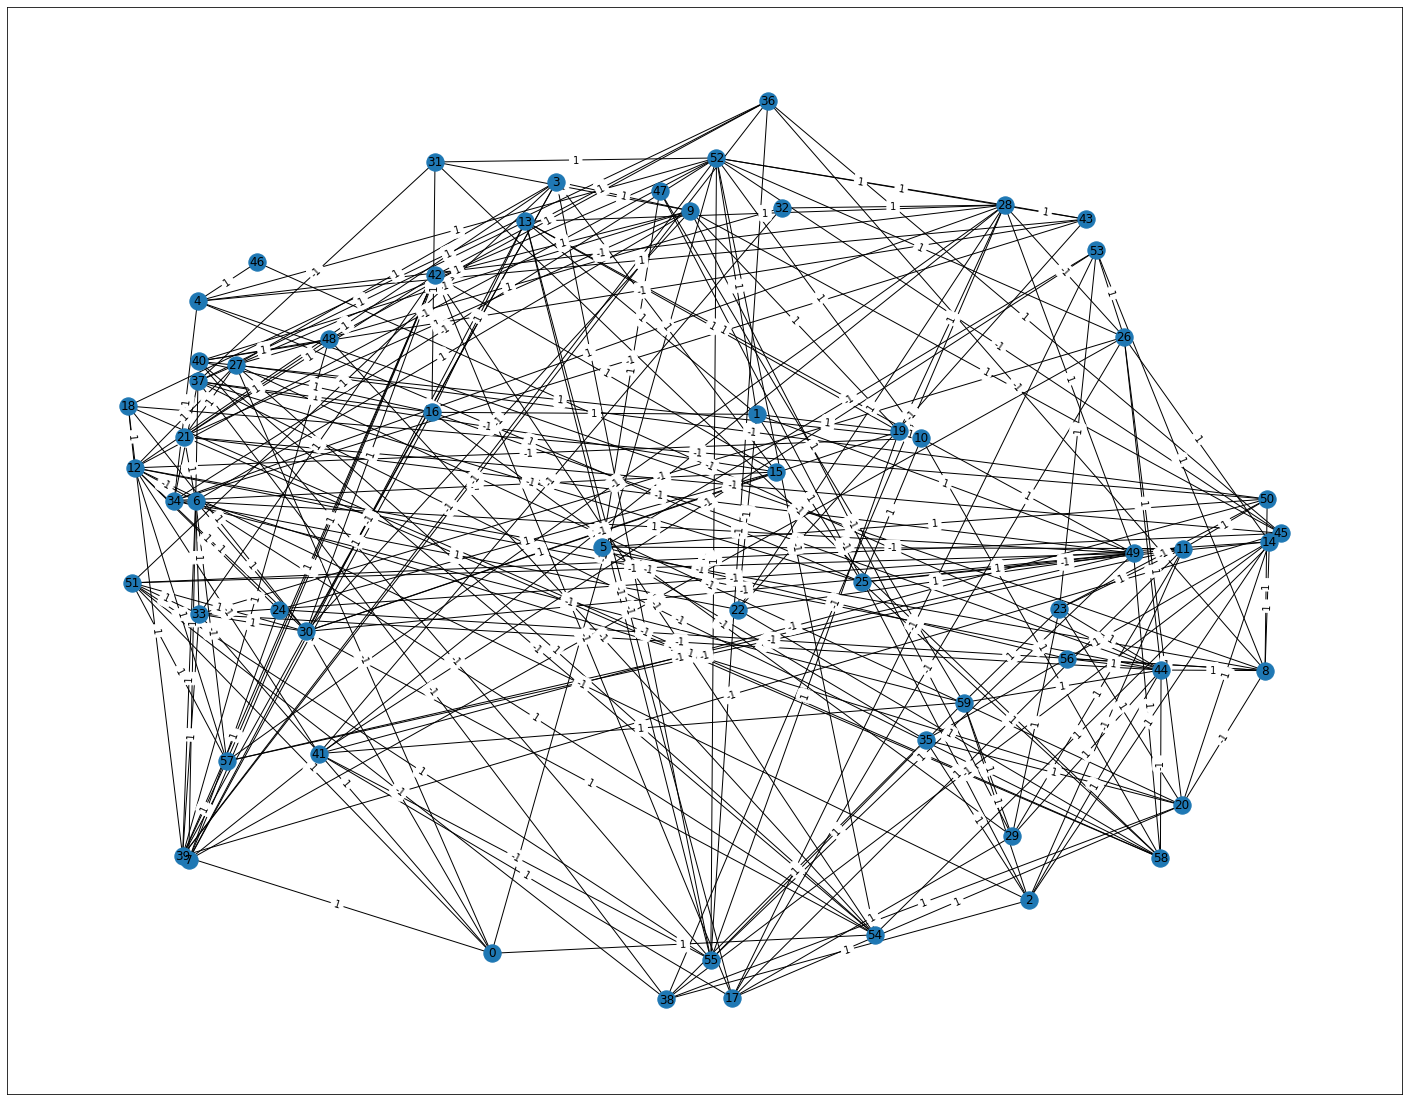

In [15]:
pos = position(G)
plotGraph(G,pos)

In [16]:
EP, EN = edgesEN(G)
HP = nx.Graph()
HN = nx.Graph()

HP.add_nodes_from(G)
HN.add_nodes_from(G)

HP.add_edges_from(EP)
HN.add_edges_from(EN)

print(f"G : #nodes= {G.number_of_nodes()}, #edges = {G.number_of_edges()}")
print(f"HP : #nodes= {HP.number_of_nodes()}, #edges = {HP.number_of_edges()}")
print(f"HN : #nodes= {HN.number_of_nodes()}, #edges = {HN.number_of_edges()}")

G : #nodes= 60, #edges = 236
HP : #nodes= 60, #edges = 150
HN : #nodes= 60, #edges = 86


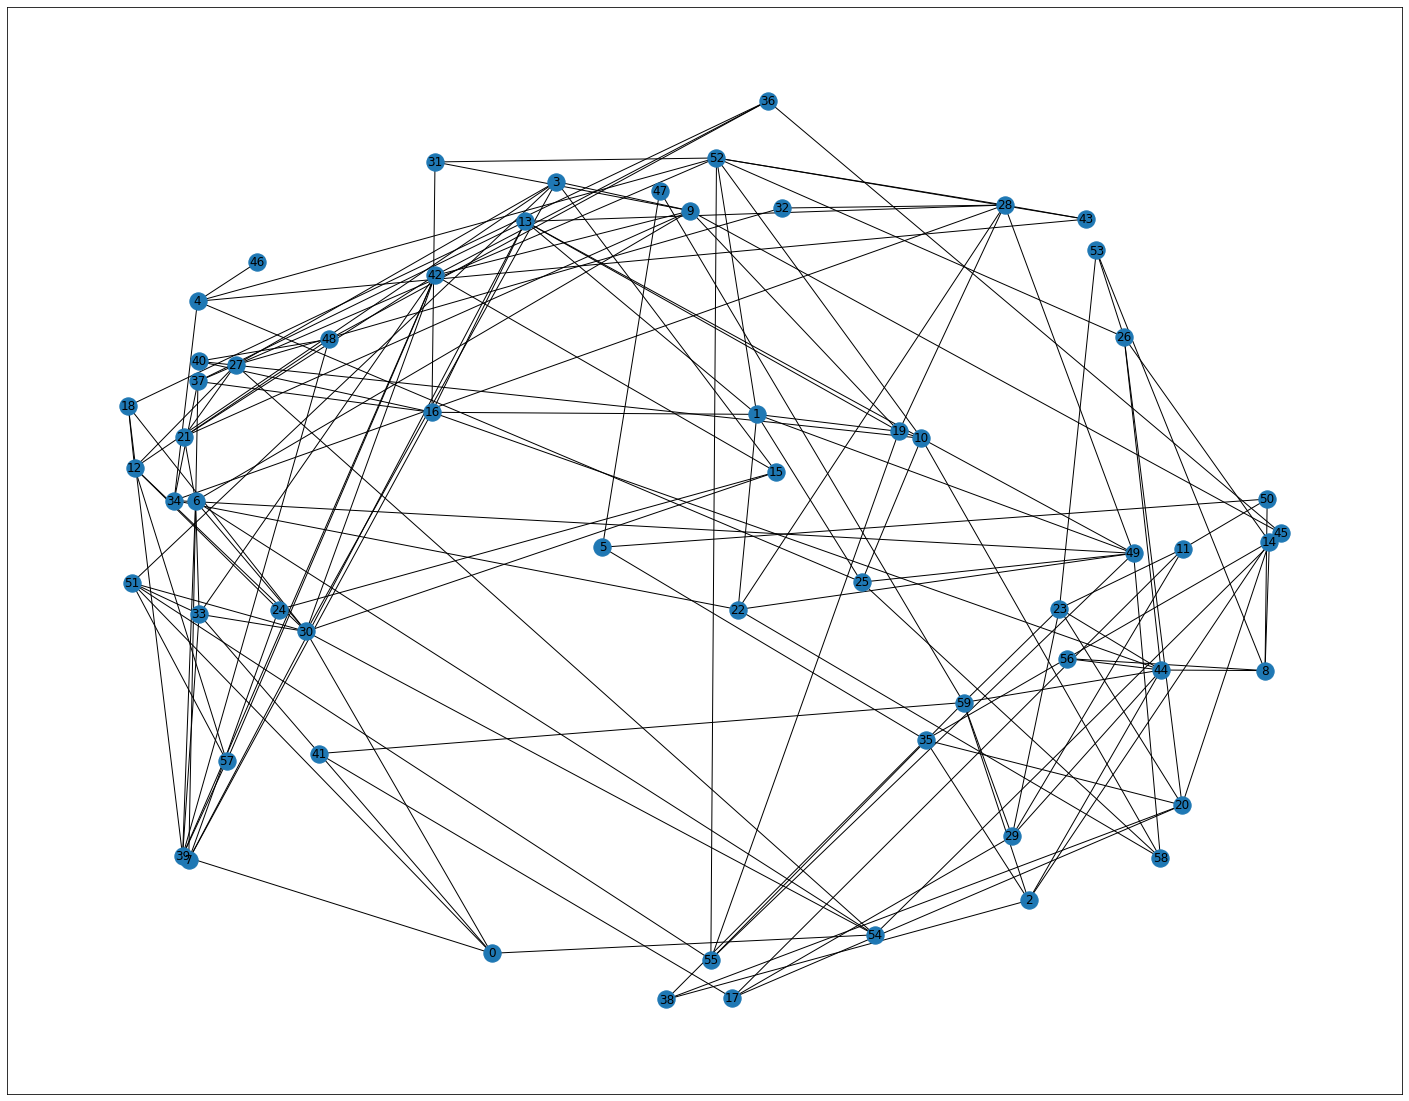

In [17]:
plotGraph(HP, pos)

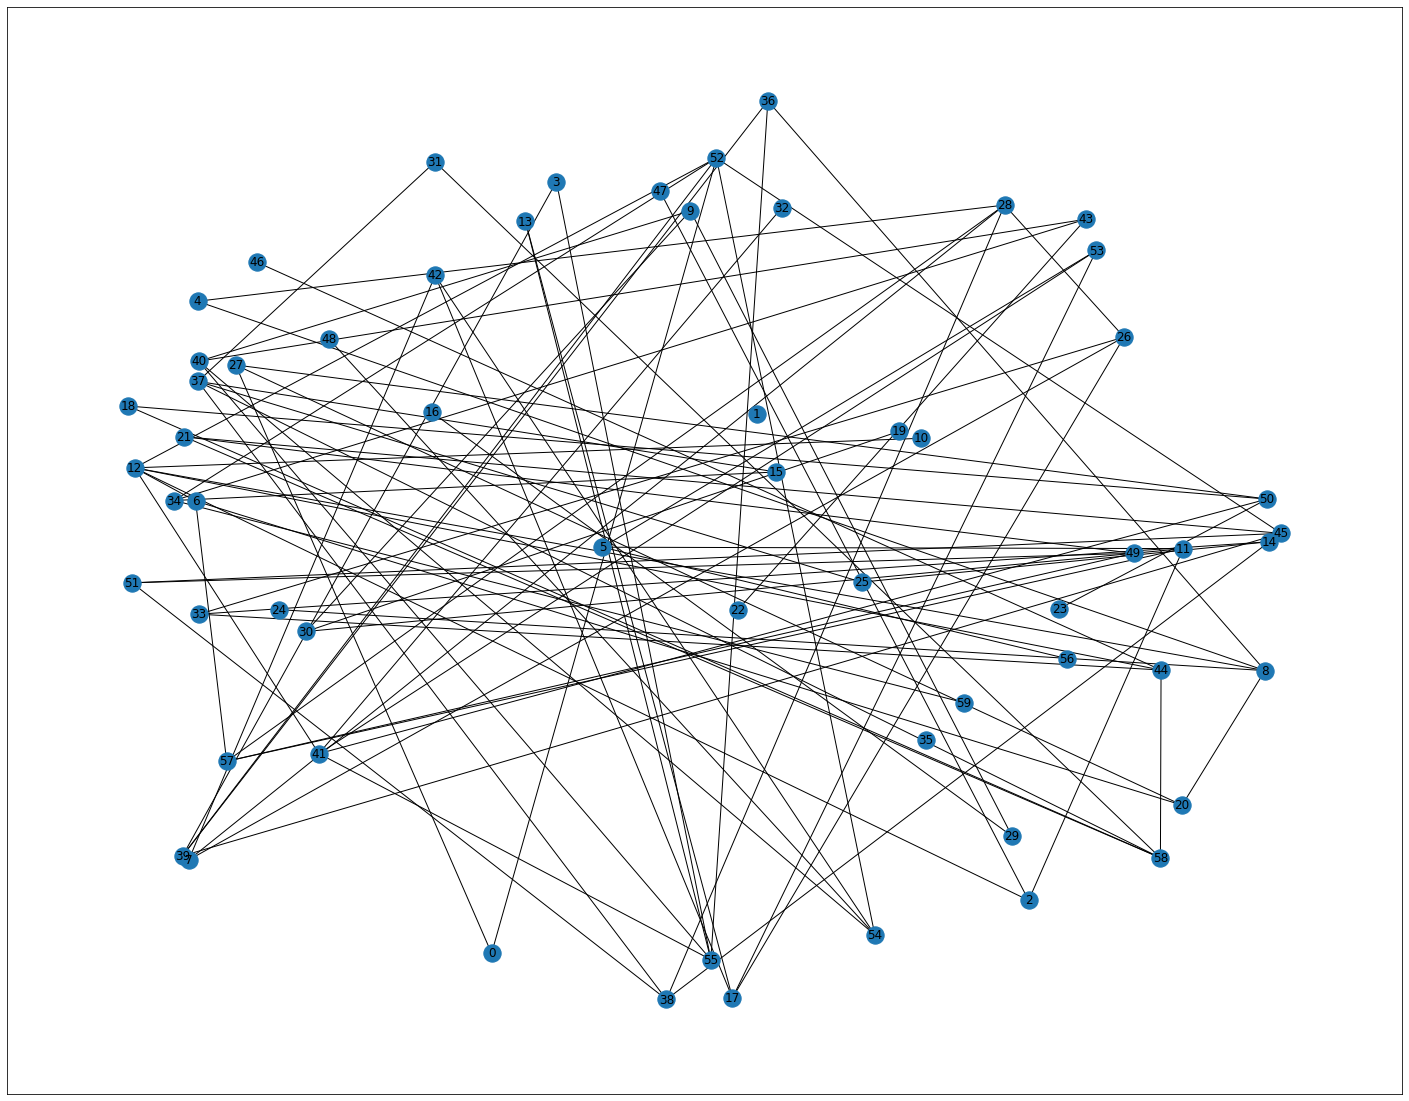

In [18]:
plotGraph(HN,pos)

In [19]:
VK = setVK(G, k_)
method = "mip"
objval, objbound, mipgap, nodecount, runtime, status, xk, yelim = edge3_formulation(G, k_, VK, EP, EN, method)

print("ub = ", objval)
print("time = ", runtime)
print("status = ", status)
print("lb = ", objbound)
print("gap = ", mipgap)
print("nodes = ", nodecount)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-19
ub =  41.0
time =  20.790088176727295
status =  1
lb =  41.0
gap =  0.0
nodes =  4551.0


In [20]:
print(xk)

[(0, 0), (1, 1), (2, 2), (3, 0), (4, 1), (5, 1), (6, 0), (7, 1), (8, 2), (9, 0), (10, 1), (11, 2), (12, 0), (13, 1), (14, 2), (15, 0), (16, 1), (17, 2), (18, 0), (19, 1), (20, 2), (21, 0), (22, 1), (23, 2), (24, 0), (25, 1), (26, 2), (27, 0), (28, 1), (29, 2), (30, 0), (31, 0), (32, 0), (33, 0), (34, 1), (35, 2), (36, 0), (37, 1), (38, 2), (39, 0), (40, 1), (41, 2), (42, 0), (43, 1), (44, 2), (45, 2), (46, 1), (47, 1), (48, 0), (49, 1), (50, 1), (51, 0), (52, 1), (53, 2), (54, 0), (55, 1), (56, 2), (57, 0), (58, 1), (59, 2)]


In [21]:
print(yelim)

[(0, 27), (2, 11), (3, 39), (4, 28), (5, 35), (6, 12), (6, 57), (7, 24), (7, 28), (8, 20), (8, 50), (9, 19), (9, 30), (9, 45), (11, 50), (13, 55), (14, 38), (16, 31), (16, 44), (17, 26), (17, 53), (22, 43), (25, 37), (26, 52), (28, 32), (31, 52), (34, 43), (34, 52), (36, 39), (36, 45), (37, 58), (40, 43), (40, 48), (40, 55), (41, 53), (42, 54), (45, 54), (47, 59), (48, 54), (51, 55), (55, 59)]


In [22]:
partition = []
for i in range(k_):
    a = []
    for v in xk:
        if v[1] == i:
            a.append(v[0])
    partition.append(set(a))
    
#partition

print("Partitions:")
for i in range(k_):
    print(f"i={i}: tam={len(partition[i])}, S[{i}]={partition[i]}")

Partitions:
i=0: tam=21, S[0]={0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 31, 32, 33, 36, 39, 42, 48, 51, 54, 57}
i=1: tam=22, S[1]={1, 4, 5, 7, 10, 13, 16, 19, 22, 25, 28, 34, 37, 40, 43, 46, 47, 49, 50, 52, 55, 58}
i=2: tam=17, S[2]={2, 35, 38, 8, 41, 11, 44, 45, 14, 17, 20, 53, 23, 56, 26, 59, 29}


In [23]:
nx.community.is_partition(G, partition)

True

In [24]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

#for key, value in partition_map.items():
#    print(f"{key}: {value}")

In [25]:
color_map = []
for node in G:
    if partition_map[node] == 0:
        color_map.append('gray')
    elif partition_map[node] == 1:
        color_map.append('green')
    else:
        color_map.append('yellow')

#node_colors = [partition_map[n] for n in G.nodes]

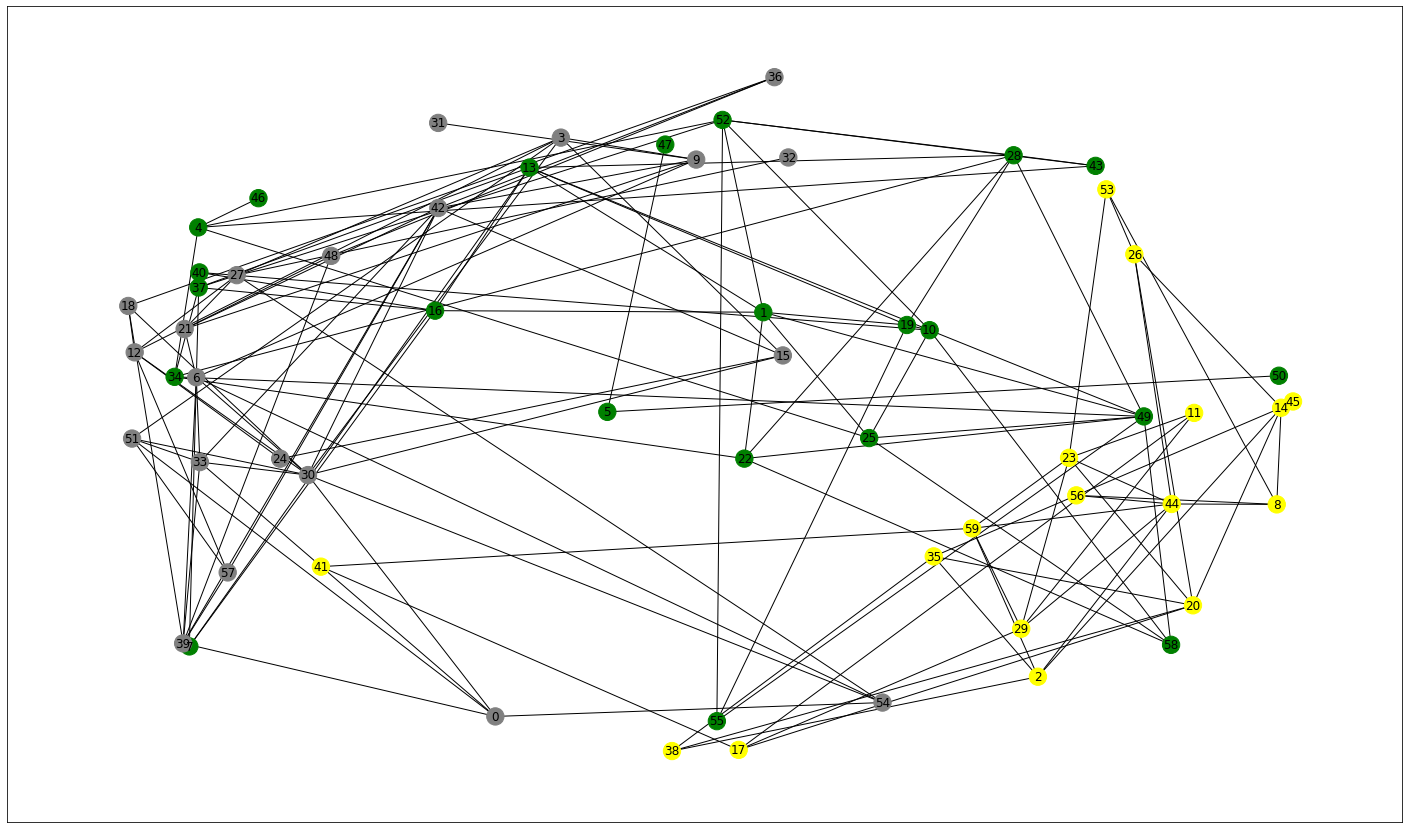

In [26]:
HP.remove_edges_from(yelim)
plt.figure(figsize=(25, 15))        
nx.draw_networkx(HP, pos, node_size=300, node_color=color_map, with_labels=True)
plt.show()

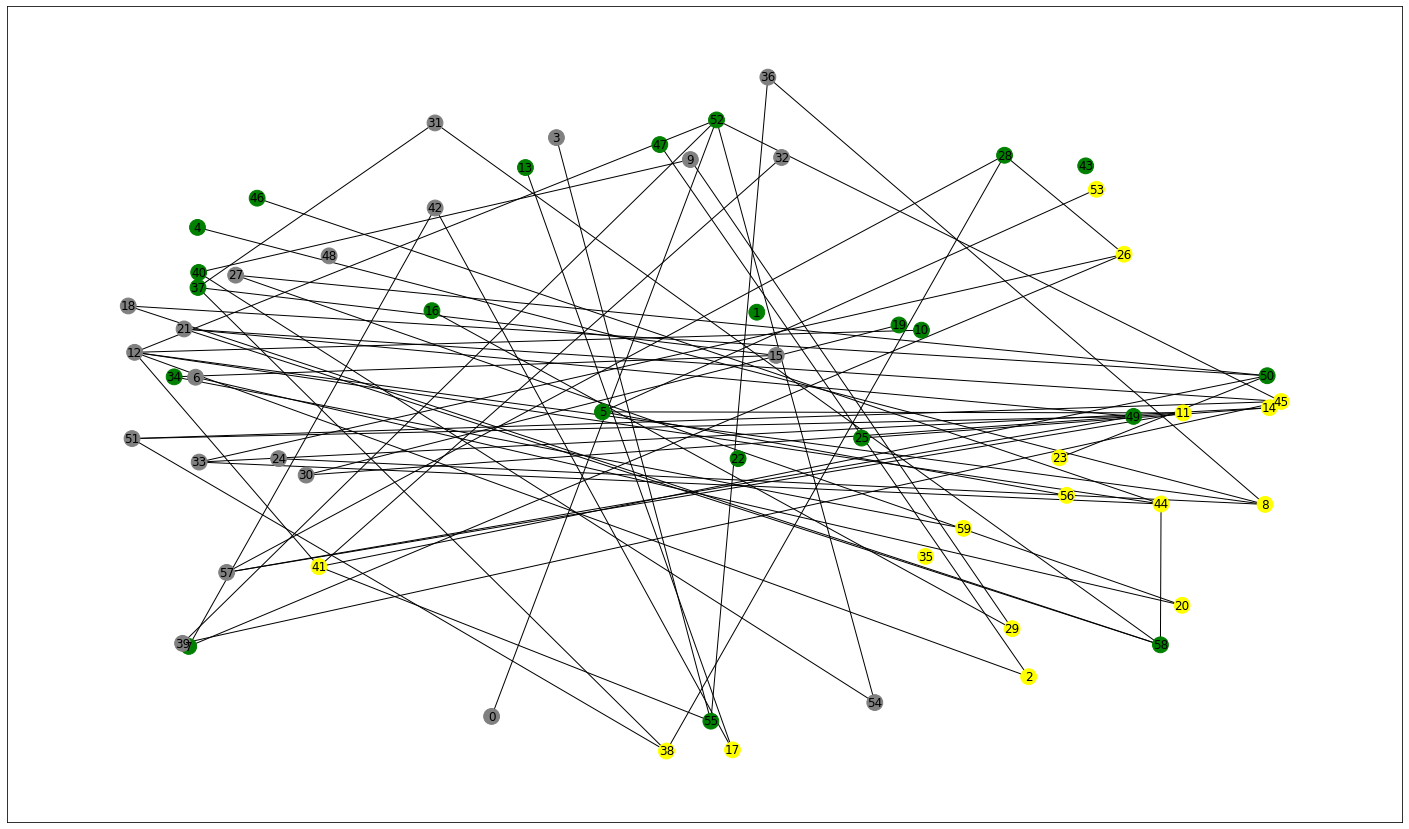

In [27]:
HN.remove_edges_from(yelim)
plt.figure(figsize=(25, 15))        
nx.draw_networkx(HN, pos, node_size=250, node_color=color_map, with_labels=True)
plt.show()

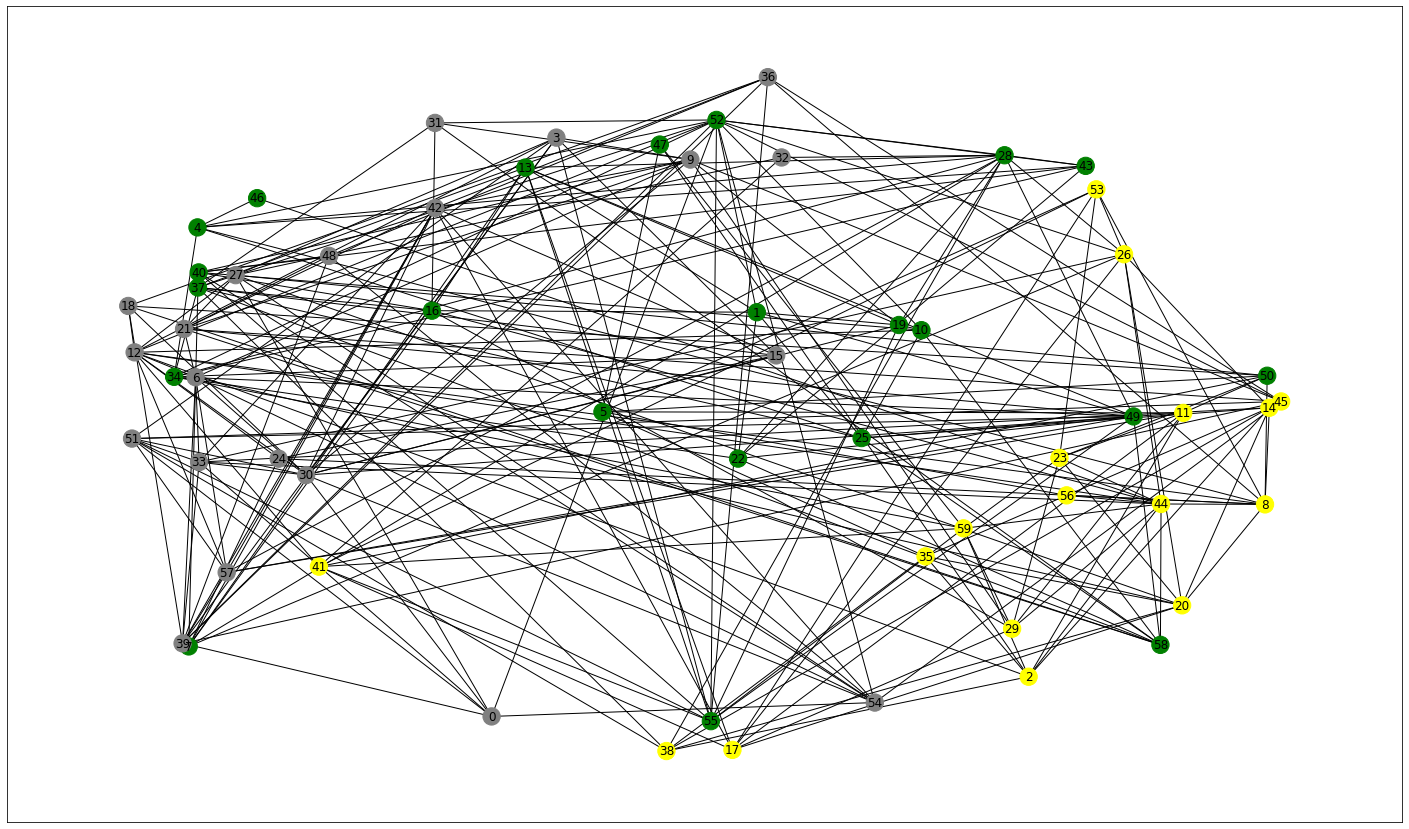

In [28]:
plt.figure(figsize=(25, 15))        
nx.draw_networkx(G, pos, node_size=300, node_color=color_map, with_labels=True)
#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()

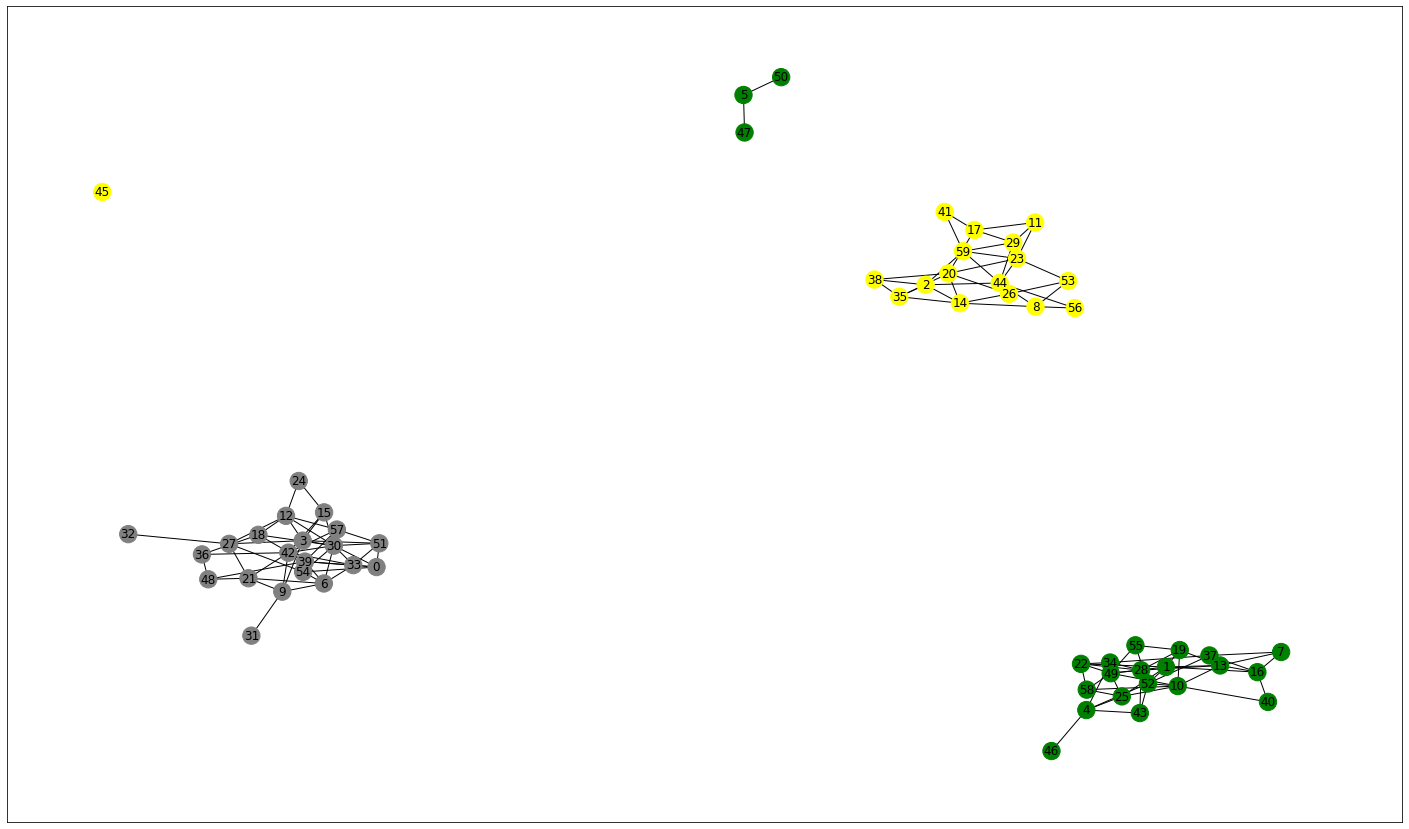

In [29]:
seed = 20532
plt.figure(figsize=(25, 15))        
pos1 = nx.spring_layout(HP, seed=seed)
nx.draw_networkx(HP, pos1, node_size=300, node_color=color_map, with_labels=True)
plt.show()